# Transforming Count Matrices

Given a sparse matrix of count data (as one gets from bag-of-words models), it is common and often effective to apply various transformations before using the resulting vectors in further downstream tasks.  In general there are two types of transformations one performs; column reweighting, and row reweighting.  For example tf-idf can be thought of as just reweighting columns by the idf factor (explained further before), where L_1 or L_2 normalization is an example of row reweighting.  

TextMAP has two mathematically founded transformer classes for modifying count matrices; InformationWeightTransformer which generalizes idf scaling, and RemoveEffectsTransformer which adjusts (and optionally normalizes) the rows to by removing the 'expected' counts.  We will look at each of these in detail below including their mathematical underpinnings. 

First, lets load some libraries and get some data to explore.

In [1]:
import sklearn.datasets
import numpy as np
import vectorizers
import textmap
import textmap.tokenizers 
import textmap.transformers
import nltk

In [2]:
news = sklearn.datasets.fetch_20newsgroups(remove=('headers', 'footers', 'quotes'))

In [3]:
long_enough = [len(t) > 100 for t in news['data']]
data = np.array(news['data'])
data = data[long_enough]
targets = np.array(news.target)
targets = targets[long_enough]
target_names = np.array(news.target_names)

Now, lets make a sparse count matrix by taking a bag of words model for documents. 

In [4]:
tokens = textmap.tokenizers.SKLearnTokenizer().fit_transform(data)

In [5]:
vectorizer = vectorizers.NgramVectorizer(min_occurrences=40)
mat = vectorizer.fit_transform(tokens)

In [6]:
mat

<10294x4984 sparse matrix of type '<class 'numpy.float32'>'
	with 832940 stored elements in Compressed Sparse Row format>

In general, an information weight transformer is trying to scale the entries of a matrix by how 'informative' a word is as a keyword for a document.  For example, as described in Church, Gale (1995):

_Both somewhatand boycott appeared approximately 1000 times in a corpus of 1989 Associated Press articles, but boycott is a better keyword because its [number of documents it appears in] is farther from what would be expected by chance (Poisson)._

So the goal of an information weight transformer is to rescale the entries of a count matrix to take into account this bias.  The most common way to do this is with an sklearn TfidfTransformer but there are several ways one cound generalize this, or several other natural transformations to apply.  In fact, one of the downsides of Tfidf is it's lack of rigourous mathematical underpinnings (even Aizawa's justifiction recognizes Tfidf as only an approximation to units of mutual information). 

## Information Weight Transformer

$\newcommand{\idf}{\mathrm{idf}}$
Generally speaking, the default InformationWeighTransformer is a higher dimensional version of TfidfTransformer (which doesn't actually use the standard idf formula for the record).   Let $D$ be the collection of $N$ documents and let $W =\{w_j\}$ be the complete set of words (tokens).  Inverse Document Frequency is defined is 

$$
\idf_j = \log \left(\frac{\#\{d \in D | w_j \in D\}}{N}\right),
$$

and an idf transformer simply scales the columns of the matrix by these values associated to each word column.  If we ignore the frequency of a word occuring in a document and consider a document to be a set of words.  Then if we sample documents uniformly we get 

$$
\idf_j = -\log \left( P(w_j \in d) \right)
$$

which (by definition) is the _amount of information_ associated to the probability.  In this way, we see that an idf-transformer changes the units of a count matrix from counts to information-weighted counts.  

Inherent in the idf-transformer is a 1-dimensional model of the vocabulary - all documents are sampled from one vocabulary.  If this wasn't the case (like documents are sampled from vocabularies of two or more topics or even form two of more languages) then the idf scaling will predominantly depend on the frequency of documents drawn from each (potentially overlapping) vocabulary.  Hence we may wish to use a higher dimensional version of idf scaling that takes into account some given number of latent vocabularies (i.e. topics). 

From a topic modelling perspective suppose we have one topic $t$ which is given by $P(w_j|t)$ which is just given by the frequency of unique words. This is precisely the topic that a 1 component pLSA decomposition of the binarized count matrix would produce.  In this case $P(t|d)=1$ for all documents as well.  Then we can re-write $\idf_j$ as 

$$
\idf_j = -\log \left(P(w_j|t)P(d|t) \times E(\mbox{unique words per document}|t)\right)
$$

However, we can take a higher dimensional topic model and thus some probability across topic to generalize idf to 

$$
idf_{i,j} = -\log \left( \sum_t P(w_j|t)P(t|d_j) \times E(\mbox{unique words per document}|t)\right)
$$

In the case of a 1 component topic model this reduces to the regular idf.  In the case of a 2-component topic model for 2 distinct vocabularies, and documents drawn exclusively from one or the other, this produces the idf weights for each set of documents from each vocabulary as if they were computed seperately.  In general, if one assumes that documents are drawn from mixture of vocabularies then the idf-weights $idf_i,j$ are applied entry-wise to the count matrix, essentially interpolating between these extreme cases. 

This is the default calculation performed by the InformationWeightTrnasformer. 

In [7]:
%%time 
# The default setting behaves like a (correct) TfidfTransformer 
info_mat = textmap.transformers.InformationWeightTransformer().fit_transform(mat)

CPU times: user 3.09 s, sys: 133 ms, total: 3.22 s
Wall time: 1.59 s


In [8]:
%%time 
# However, we can also assume that our documents are drawn from a combination of 2 or more vocabularies
info_mat = textmap.transformers.InformationWeightTransformer(n_components=2).fit_transform(mat)

CPU times: user 1.46 s, sys: 60.1 ms, total: 1.52 s
Wall time: 935 ms


Now considering documents as multinomials over information weighted words, we again can embed them with UMAP using hellinger distance. 

In [9]:
import umap
import matplotlib.pyplot as plt

In [10]:
# We are just going to set a random seed for reproducibility 
mapper = umap.UMAP(metric = "hellinger", random_state=42).fit(info_mat)

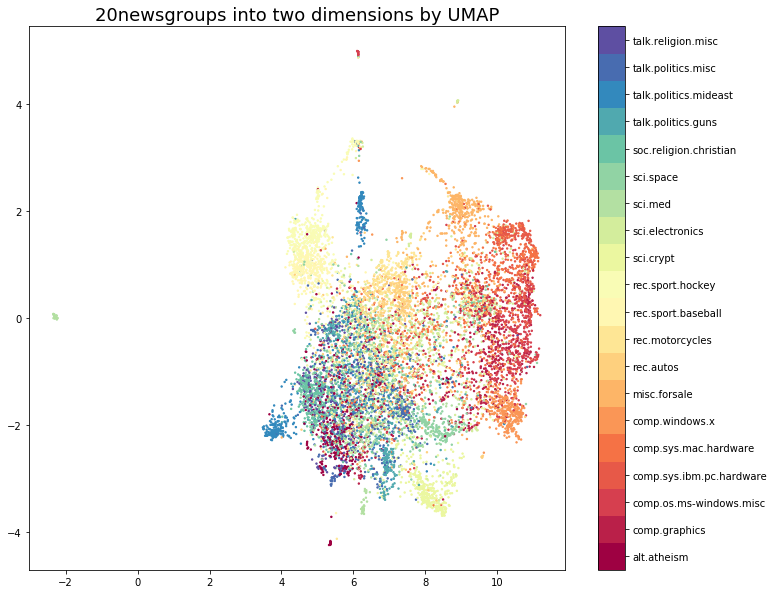

In [11]:
embedding = mapper.embedding_
fig, ax = plt.subplots(figsize=(12, 10))
color = targets.astype(int)
plt.scatter(embedding[:, 0], embedding[:, 1], c=color, cmap="Spectral", s=2)
plt.title("20newsgroups into two dimensions by UMAP", fontsize=18)
cbar = plt.colorbar(boundaries=np.arange(21)-0.5)
cbar.set_ticks(np.arange(20))
cbar.set_ticklabels(target_names)

## Other information weightings

#### Average idf:
One may instead wish to take the weighted average of the idf values per topic as a means to generalize idf weights. In this case 

$$
idf_{i,j}^{avg} = -\sum_t P(t|d_j) \log \left(P(w_j|t) \times E(\mbox{unique words per document}|t)\right)
$$

This is also a built-in option in called 'average idf'.  Notice that with a 1-component topic model this also reproduces the usual idf weights. 

In [12]:
%%time 
# We can also assume that our documents are drawn from a combination of 2 or more vocabularies
info_mat = textmap.transformers.InformationWeightTransformer(n_components=2, 
                                                             information_function = "average_idf",
                                                            ).fit_transform(mat)


CPU times: user 2.15 s, sys: 76.3 ms, total: 2.22 s
Wall time: 947 ms


In [13]:
# We are just going to set a random seed for reproducibility 
mapper = umap.UMAP(metric = "hellinger", random_state=42).fit(info_mat)

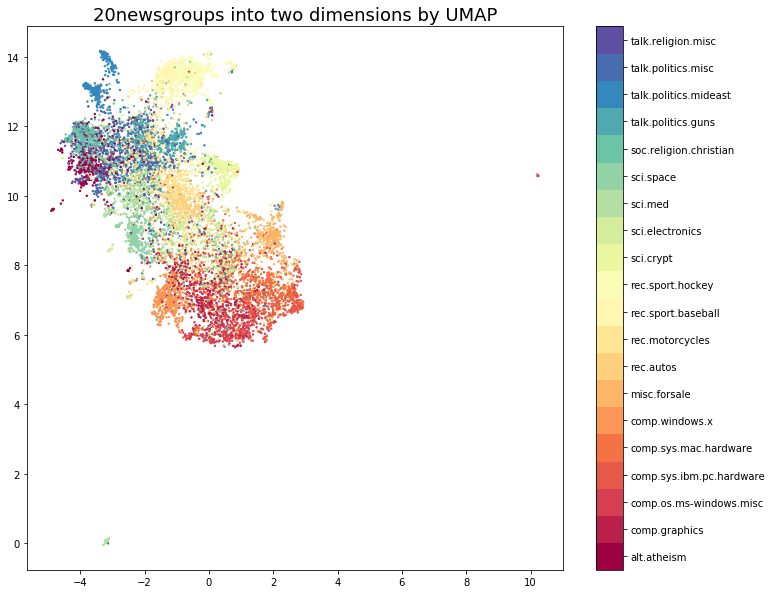

In [14]:
embedding = mapper.embedding_
fig, ax = plt.subplots(figsize=(12, 10))
color = targets.astype(int)
plt.scatter(embedding[:, 0], embedding[:, 1], c=color, cmap="Spectral", s=2)
plt.title("20newsgroups into two dimensions by UMAP", fontsize=18)
cbar = plt.colorbar(boundaries=np.arange(21)-0.5)
cbar.set_ticks(np.arange(20))
cbar.set_ticklabels(target_names)

#### Column KL-divergence:


As mentioned, idf is trying to capture the bais in a words distribution as compared to random.  When phrased in such a fashion, the natural way to do that is measure the KL-divergence between the data and a prior/null model. In particular, a reasonable null model is a the reconstruction of a low rank topic model.  So, this time instead of taking a low rank decomposition of the binarized matrix we will use the count matrix.  Then, if we write $P(w_j)$ for the actual distribution of words over documents and $Q(w_j)$ for that predicted by the low-rank model we can compute the KL-divergence

$$
idf^{KL}_{j} = \sum_i P(w_j)log\left(\frac{P(w_j)}{Q(w_j)}\right)
$$

and scale columns by these values. 

In [15]:
%%time 
# We can also assume that our documents are drawn from a combination of 2 or more vocabularies
info_mat = textmap.transformers.InformationWeightTransformer(n_components=2, 
                                                             information_function = "column_kl",
                                                            ).fit_transform(mat)



CPU times: user 16.8 s, sys: 61 ms, total: 16.8 s
Wall time: 15.6 s


In [16]:
# We are just going to set a random seed for reproducibility 
mapper = umap.UMAP(metric = "hellinger", random_state=42).fit(info_mat)

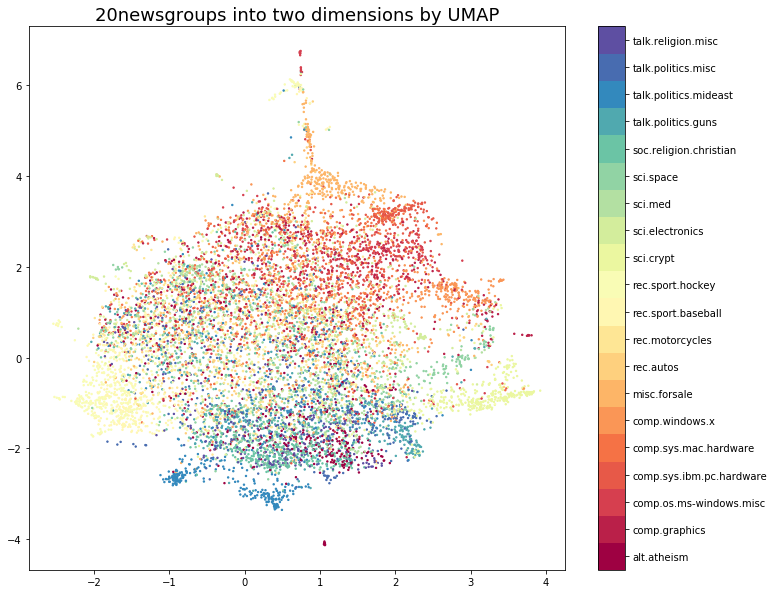

In [17]:
embedding = mapper.embedding_
fig, ax = plt.subplots(figsize=(12, 10))
color = targets.astype(int)
plt.scatter(embedding[:, 0], embedding[:, 1], c=color, cmap="Spectral", s=2)
plt.title("20newsgroups into two dimensions by UMAP", fontsize=18)
cbar = plt.colorbar(boundaries=np.arange(21)-0.5)
cbar.set_ticks(np.arange(20))
cbar.set_ticklabels(target_names)

#### Entry-wise Bernoulli:

As mentioned above, anatural way to rescale entries is by the KL-divergence between the data and a prior/null model, and a reasonable null model is the reconstruction of a low rank topic model.  If we think of a document as a multinomial distribution then L_1 normalizing the rows is just taking the MLE for these parameters.  Entry-wise we can consider each of these as a Bernoulli trial with probability $P(w_j|d_i)$.  If we let $Q(w_j|d_i)$ be the predicted value by the low-rank model we can compute the KL-divergence between these Bernoilli distributions as 

$$
idf^{Ber}_{i,j} = P(w_j)log\left(\frac{P(w_j)}{Q(w_j)}\right) + (1-P(w_j))log\left(\frac{1-P(w_j)}{1-Q(w_j)}\right)
$$

and scale entries by these values. 

In [18]:
%%time 
# We can also assume that our documents are drawn from a combination of 2 or more vocabularies
info_mat = textmap.transformers.InformationWeightTransformer(n_components=2, 
                                                             information_function = "bernoulli_kl",
                                                            ).fit_transform(mat)




CPU times: user 10.9 s, sys: 45.1 ms, total: 10.9 s
Wall time: 9.72 s


In [19]:
# We are just going to set a random seed for reproducibility 
mapper = umap.UMAP(metric = "hellinger", random_state=42).fit(info_mat)

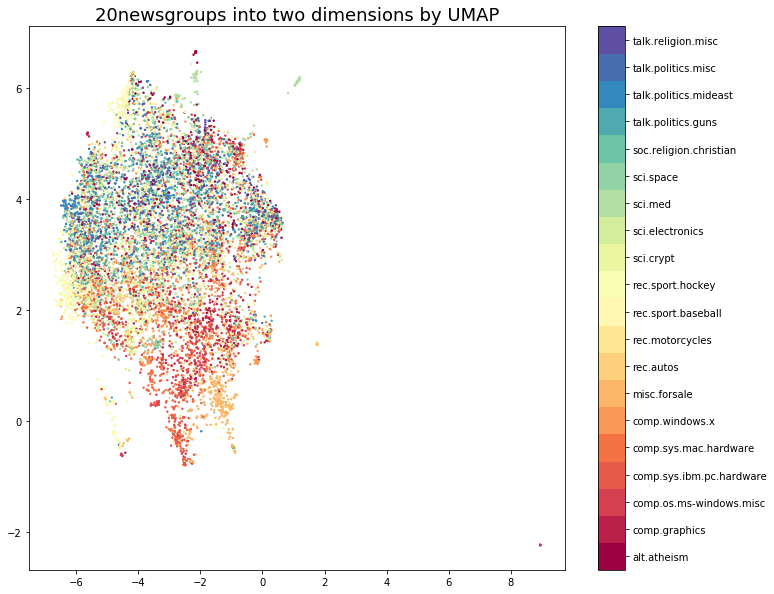

In [20]:
embedding = mapper.embedding_
fig, ax = plt.subplots(figsize=(12, 10))
color = targets.astype(int)
plt.scatter(embedding[:, 0], embedding[:, 1], c=color, cmap="Spectral", s=2)
plt.title("20newsgroups into two dimensions by UMAP", fontsize=18)
cbar = plt.colorbar(boundaries=np.arange(21)-0.5)
cbar.set_ticks(np.arange(20))
cbar.set_ticklabels(target_names)

## Remove Effects Transformer

Veiwing a document as a multinomial has the downside, especially for longer documents, that most words occur about as frequently as one would expect.  In some sense, the keywords of a document are those words that occur more than expected.  Hence, one may wish to consider a document as a mixture of multinomials, a causal one which represents the distribution of keywords, and a background or null model, which represents the mixture of words that arrise naturally from grammer independent of the particular document.  Viewed in such a fashion, one would like to compare documents based on the similarity of their keyword distributions. 

Mathematically, let $P_d$ be the distribution of tokens in a document, and let $P_b$ be the background model for the distribution words.  Then by assumption $P_d$ is an (unknown) mixture of $P_b$ and $P_k$, where $P_k$ is the causal distribution of keywords, i.e.

$$
P_d = sP_k + (1-s)P_b
$$

As in other cases, given some training data, we can comute $P_b$ as the reconstruction of $P_d$ from some low-rank topic model (like via pLSA or EnsTop).  Then given $P_d$ (as the MLE of a count matrix) we can use an Expectation Maximization algorithm to solve for $s$ and $P_k$.  However, the maximal likelihood estimation is that $s=1$ and $P_k = P_d$ as $P_k$ is the MLE. So we have to set a prior on $s$ to force some kind of actual mixture.  So we give $s$ a Beta prior given by 

$$
\beta([1, em\_background\_prior]*em\_prior\_strength)
$$

so we can run the EM algorithms to solve for $s$ and $P_k$ non-trivially.  The higher we set the em_background_prior the smaller the value of $s$ we expect (it will only increase during iterations of the algorithm), and the higher we set em_prior_strength the lower the variance of the results.  We can also control the number of components in our background model, which will reduce our reconstruction error.   As the number of components grows, $P_b$ will approach $P_d$ making it more restrictive for a word to contribute to the distribution of keywords $P_k$. 


In [21]:
%%time 
re_transformer0 = textmap.transformers.RemoveEffectsTransformer(n_components = 2).fit(mat)
re_mat = re_transformer0.transform(mat)
re_mat

CPU times: user 6.04 s, sys: 55 ms, total: 6.09 s
Wall time: 4.43 s


<10294x4984 sparse matrix of type '<class 'numpy.float32'>'
	with 622296 stored elements in Compressed Sparse Row format>

Notice that the difference in the numner of non-zeros before and after the transformation:

In [22]:
mat

<10294x4984 sparse matrix of type '<class 'numpy.float32'>'
	with 832940 stored elements in Compressed Sparse Row format>

The EM algorithm will replace and values that become lower than em_threshold with 0s (as they are not keywords). It is an iterative algorithm that eventually converges.  The stopping critea is when the change in the newly computed value of $s$ is less than em_precision. 

The default prior is $\beta (0.2, 1)$.  We can look at the resulting mixed_weights (the values of $s$ per document) that this results in. 

(array([   9.,   24.,  340., 1599., 3680., 3031., 1206.,  331.,   63.,
          11.]),
 array([0.16680188, 0.19861287, 0.23042387, 0.26223484, 0.29404584,
        0.32585683, 0.3576678 , 0.3894788 , 0.4212898 , 0.45310077,
        0.48491177], dtype=float32),
 <a list of 10 Patch objects>)

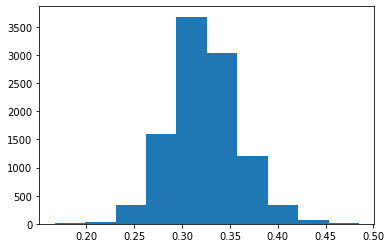

In [23]:
plt.hist(re_transformer0.mix_weights_)

Embedding the resulting keyword distribution as the representation of each document we get 

In [24]:
# We are just going to set a random seed for reproducibility 
mapper = umap.UMAP(metric = "hellinger", random_state=42).fit(re_mat)

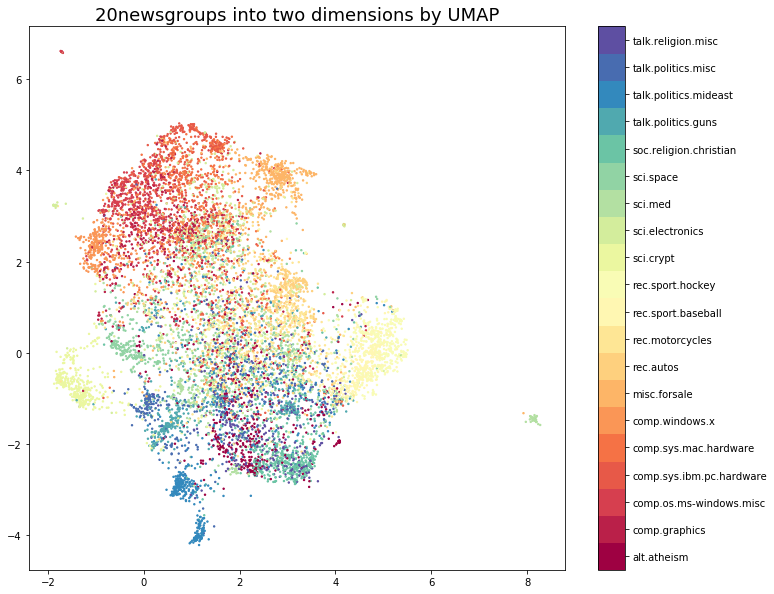

In [25]:
embedding = mapper.embedding_
fig, ax = plt.subplots(figsize=(12, 10))
color = targets.astype(int)
plt.scatter(embedding[:, 0], embedding[:, 1], c=color, cmap="Spectral", s=2)
plt.title("20newsgroups into two dimensions by UMAP", fontsize=18)
cbar = plt.colorbar(boundaries=np.arange(21)-0.5)
cbar.set_ticks(np.arange(20))
cbar.set_ticklabels(target_names)

#### If we turn up the prior and its strength (a lot just to exagerate the example) then we can see the effect this has. 

In [26]:
%%time 
re_transformer = textmap.transformers.RemoveEffectsTransformer(n_components = 2,
                                                               em_background_prior = 10,
                                                               em_prior_strength = 10).fit(mat)
re_mat = re_transformer.transform(mat)
re_mat

CPU times: user 4.48 s, sys: 37.5 ms, total: 4.52 s
Wall time: 2.82 s


<10294x4984 sparse matrix of type '<class 'numpy.float32'>'
	with 498381 stored elements in Compressed Sparse Row format>

(array([  13.,   91.,  925., 3756., 3727., 1380.,  313.,   77.,    8.,
           4.]),
 array([0.09094749, 0.09149338, 0.09203928, 0.09258518, 0.09313107,
        0.09367697, 0.09422286, 0.09476876, 0.09531465, 0.09586055,
        0.09640644], dtype=float32),
 <a list of 10 Patch objects>)

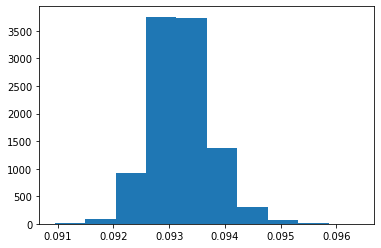

In [27]:
plt.hist(re_transformer.mix_weights_)

In [28]:
# We are just going to set a random seed for reproducibility 
mapper = umap.UMAP(metric = "hellinger", random_state=42).fit(re_mat)

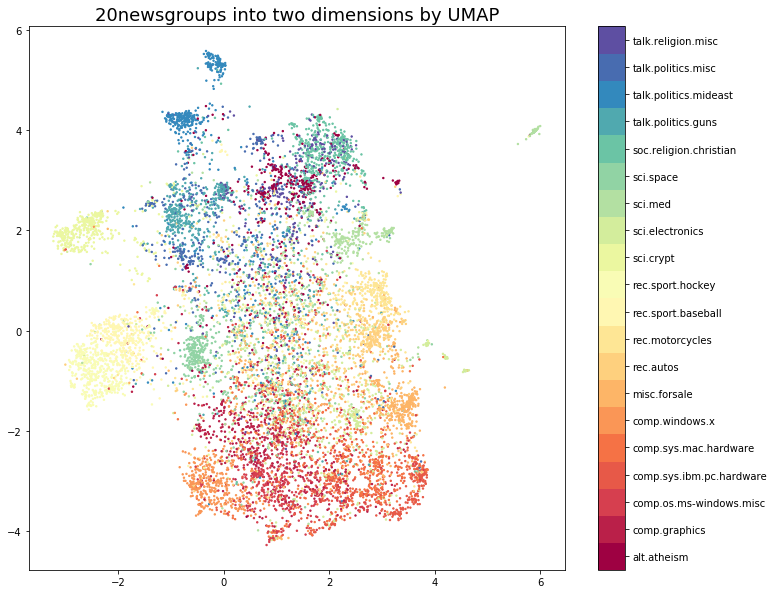

In [29]:
embedding = mapper.embedding_
fig, ax = plt.subplots(figsize=(12, 10))
color = targets.astype(int)
plt.scatter(embedding[:, 0], embedding[:, 1], c=color, cmap="Spectral", s=2)
plt.title("20newsgroups into two dimensions by UMAP", fontsize=18)
cbar = plt.colorbar(boundaries=np.arange(21)-0.5)
cbar.set_ticks(np.arange(20))
cbar.set_ticklabels(target_names)